## Import data

In [1]:
import pandas as pd 
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
df = pd.read_csv('fp.csv',index_col=0)

In [2]:
df.head()

,Name,PubChem CID,Observed logFM,Predicted logFM,SMILES,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,Oxychlordane,33772,-1.02,-0.80,C12C(C(C3(C1O3)Cl)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DDE,3035,-0.98,-0.64,C1=CC(=CC=C1C(=C(Cl)Cl)C2=CC=C(C=C2)Cl)Cl,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mifepristone,4196,-0.96,-0.41,CC#CC1(CCC2C1(CC(C3=C4CCC(=O)C=C4CCC23)C5=CC=C...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Atazanavir,148192,-0.89,-0.70,CC(C)(C)[C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@H]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Nonachlor,19520,-0.84,-1.00,C12C(C(C(C1Cl)Cl)Cl)C3(C(=C(C2(C3(Cl)Cl)Cl)Cl)...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data preprocessing

In [3]:
df.drop(df.std()[df.std() == 0].index.values,axis=1,inplace=True)
df.head()

,Name,PubChem CID,Observed logFM,Predicted logFM,SMILES,2,4,5,6,7,...,2024,2026,2029,2033,2035,2037,2041,2044,2045,2046
0,Oxychlordane,33772,-1.02,-0.80,C12C(C(C3(C1O3)Cl)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DDE,3035,-0.98,-0.64,C1=CC(=CC=C1C(=C(Cl)Cl)C2=CC=C(C=C2)Cl)Cl,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mifepristone,4196,-0.96,-0.41,CC#CC1(CCC2C1(CC(C3=C4CCC(=O)C=C4CCC23)C5=CC=C...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Atazanavir,148192,-0.89,-0.70,CC(C)(C)[C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@H]...,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
4,Nonachlor,19520,-0.84,-1.00,C12C(C(C(C1Cl)Cl)Cl)C3(C(=C(C2(C3(Cl)Cl)Cl)Cl)...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [4]:
X = df.drop(['Name','PubChem CID','SMILES','Observed logFM','Predicted logFM'],axis=1)
X.head()

,2,4,5,6,7,10,17,18,19,22,...,2024,2026,2029,2033,2035,2037,2041,2044,2045,2046
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
from sklearn import preprocessing
sscaler = preprocessing.StandardScaler()
X = sscaler.fit_transform(X)

## Split data into train and test

In [6]:
TRAIN = 41

In [7]:
X_train = X[:TRAIN]
X_test = X[TRAIN:]

In [8]:
y = df['Observed logFM']
y = np.array(y)
y_train = y[:TRAIN]
y_test = y[TRAIN:]

## Leave One Out Cross Validation

In [9]:
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

In [10]:
def LOOCV(reg):
    rmse_min = np.inf
    for train_index, test_index in loo.split(X_train):
        loo_x_train, loo_x_test = X_train[train_index], X_train[test_index]
        loo_y_train, loo_y_test = y_train[train_index], y_train[test_index]
        reg.fit(loo_x_train,loo_y_train)
        result = reg.predict(X_train)
        rmse = mean_squared_error(y_train, result,squared=False)
        if rmse < rmse_min:
            rmse_min = rmse     
            best_model = reg
    return best_model

In [11]:
def True_Pred_map(y_pred, filename):
    if y_pred.size == TRAIN:
        y_pred_author = df['Predicted logFM'][:TRAIN]
        y_true = y_train
    else:
        y_pred_author = df['Predicted logFM'][TRAIN:]
        y_true = y_test
    RMSE = mean_squared_error(y_true,y_pred,squared=False)
    R2 = r2_score(y_true, y_pred)
    RMSE_author = mean_squared_error(y_true,y_pred_author,squared=False)
    R2_author = r2_score(y_true, y_pred_author)
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter(y_true, y_pred,label='Prediction')
    ax.scatter(y_true, y_pred_author,label='Author\'s Prediction')
    ax.set_xlabel('Observed logFM', fontsize=15)
    ax.set_ylabel('Predicted logFM', fontsize=15)
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    pred_df = pd.concat([y_true,y_pred],axis=1)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'-', color="tab:red")
    plt.text(0.05, 0.95, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=12,color="tab:blue")
    plt.text(0.05, 0.9, 'Q2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=12,color="tab:blue")
    plt.text(0.05, 0.85, 'RMSE = {}'.format(str(round(RMSE_author, 5))), transform=ax.transAxes, fontsize=12,color="tab:orange")
    plt.text(0.05, 0.8, 'Q2 = {}'.format(str(round(R2_author, 5))), transform=ax.transAxes, fontsize=12,color="tab:orange")
    plt.legend(loc="lower right")
    if y_pred.size == TRAIN:
        plt.title("ECFP4 Fingerprint "+filename+" (train data)",fontsize=15)
        plt.savefig("./output/fp_"+filename+"_train.png",dpi=300)
    else:
        plt.title("ECFP4 Fingerprint "+filename+" (test data)",fontsize=15)
        plt.savefig("./output/fp_"+filename+"_test.png",dpi=300)

    y_pred = pd.Series(y_pred,name="Predicted logFM")
    y_true = pd.Series(y_true,name="Observed logFM")
    y_pred_author = pd.Series(y_pred_author,name="Author\'s Prediction").reset_index(drop=True)
    if y_pred.size == TRAIN:
        name = df['Name'][:TRAIN].reset_index(drop=True)
        pubchem_cid = df['PubChem CID'][:TRAIN].reset_index(drop=True)
    else:
        name = df['Name'][TRAIN:].reset_index(drop=True)
        pubchem_cid = df['PubChem CID'][TRAIN:].reset_index(drop=True)
    df_comp = pd.concat([name,pubchem_cid,y_true,y_pred,y_pred_author],axis=1)
    if y_pred.size == TRAIN:
        df_comp.to_csv("./output/fp_"+filename+"_train.csv",float_format='%.2f',index=False)
    else:
        df_comp.to_csv("./output/fp_"+filename+"_test.csv",float_format='%.2f',index=False)

### Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg = LOOCV(reg)

y_pred = reg.predict(X_train)
rmse_train = mean_squared_error(y_train,y_pred,squared=False)
r2_train = r2_score(y_train,y_pred)

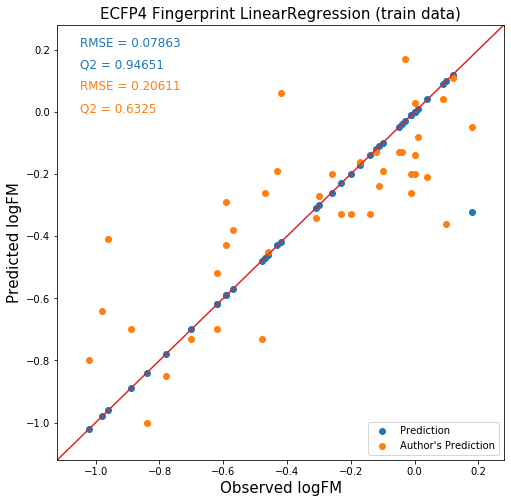

In [13]:
True_Pred_map(y_pred,"LinearRegression")

In [14]:
y_pred = reg.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)
r2_test = r2_score(y_test,y_pred)

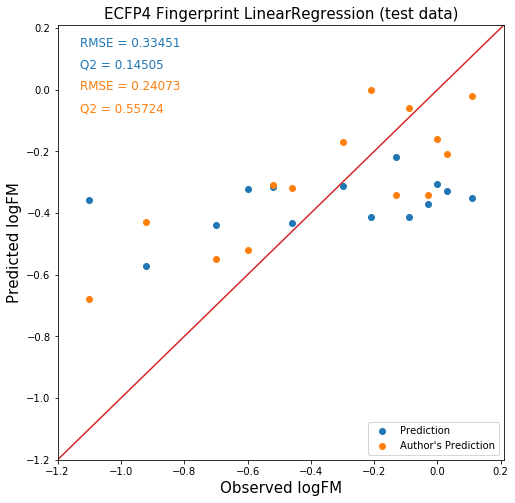

In [15]:
True_Pred_map(y_pred,"LinearRegression")

In [16]:
print("RMSE diff:", abs(rmse_train - rmse_test))
print("R2 diff:", abs(r2_train - r2_test))

RMSE diff: 0.25587753865844287
R2 diff: 0.8014544379558736


### Ridge Regression

In [17]:
from sklearn.linear_model import Ridge

def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e0, 1e2)
    reg = Ridge(alpha=alpha,random_state=0)
    reg = LOOCV(reg)
    y_pred = reg.predict(X_train)
    return 1 - r2_score(y_train,y_pred)

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)
print(study.best_trial)

[I 2020-10-27 11:01:28,114] A new study created in memory with name: no-name-c97d29d5-2a79-4e3f-bfee-89ba267b9e9a
[I 2020-10-27 11:01:28,273] Trial 0 finished with value: 0.054267310079011644 and parameters: {'alpha': 2.6265754364835034}. Best is trial 0 with value: 0.054267310079011644.
[I 2020-10-27 11:01:28,363] Trial 1 finished with value: 0.0576857389841956 and parameters: {'alpha': 29.852395221014454}. Best is trial 0 with value: 0.054267310079011644.
[I 2020-10-27 11:01:28,438] Trial 2 finished with value: 0.05574815352423346 and parameters: {'alpha': 19.245365956799933}. Best is trial 0 with value: 0.054267310079011644.
[I 2020-10-27 11:01:28,499] Trial 3 finished with value: 0.05426046471844792 and parameters: {'alpha': 2.0138335495067547}. Best is trial 3 with value: 0.05426046471844792.
[I 2020-10-27 11:01:28,566] Trial 4 finished with value: 0.06627743025363042 and parameters: {'alpha': 61.75245034250382}. Best is trial 3 with value: 0.05426046471844792.
[I 2020-10-27 11:01

In [18]:
reg = Ridge(alpha=study.best_params['alpha'],random_state=0)
reg = LOOCV(reg)

y_pred = reg.predict(X_train)
rmse_train = mean_squared_error(y_train,y_pred,squared=False)
r2_train = r2_score(y_train,y_pred)

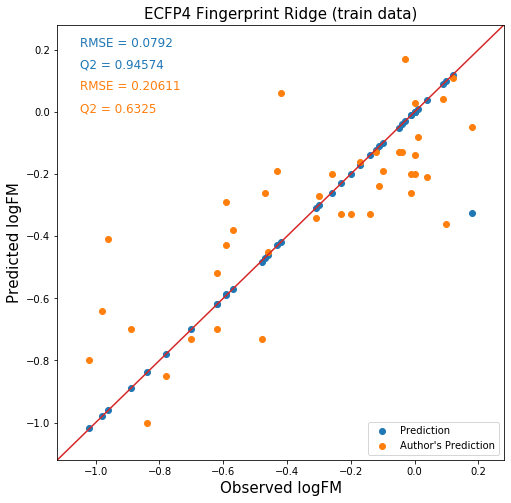

In [19]:
True_Pred_map(y_pred,"Ridge")

In [20]:
y_pred = reg.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)
r2_test = r2_score(y_test,y_pred)

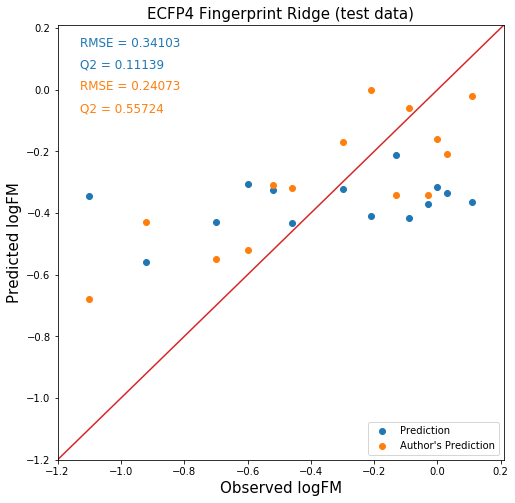

In [21]:
True_Pred_map(y_pred,"Ridge")

In [22]:
print("RMSE diff:", abs(rmse_train - rmse_test))
print("R2 diff:", abs(r2_train - r2_test))

RMSE diff: 0.2618394534807993
R2 diff: 0.8343533090383874


### Support Vector Regression

In [23]:
from sklearn.svm import SVR

def objective(trial):
    svr_c = trial.suggest_loguniform('svr_c', 1e0, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-1, 1e1)
    reg = SVR(C=svr_c, epsilon=epsilon)
    reg = LOOCV(reg)
    y_pred = reg.predict(X_train)
    return 1 - r2_score(y_train,y_pred)

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)
print(study.best_trial)

 Best is trial 1 with value: 0.1527619960436697.
[I 2020-10-27 11:01:38,696] Trial 11 finished with value: 0.14275557192031996 and parameters: {'svr_c': 89.15508259029373, 'epsilon': 0.10272517699149332}. Best is trial 11 with value: 0.14275557192031996.
[I 2020-10-27 11:01:38,830] Trial 12 finished with value: 0.47129725627080554 and parameters: {'svr_c': 66.62468979691278, 'epsilon': 0.2525265993426569}. Best is trial 11 with value: 0.14275557192031996.
[I 2020-10-27 11:01:38,980] Trial 13 finished with value: 0.4586765661278688 and parameters: {'svr_c': 3.127001099582552, 'epsilon': 0.24728242493423508}. Best is trial 11 with value: 0.14275557192031996.
[I 2020-10-27 11:01:39,150] Trial 14 finished with value: 0.15002764278839875 and parameters: {'svr_c': 89.27289210418489, 'epsilon': 0.10724030909526854}. Best is trial 11 with value: 0.14275557192031996.
[I 2020-10-27 11:01:39,281] Trial 15 finished with value: 0.4782592352055153 and parameters: {'svr_c': 86.7416378146614, 'epsilon

In [24]:
reg = SVR(C=study.best_params['svr_c'],epsilon=study.best_params['epsilon'])
reg = LOOCV(reg)

y_pred = reg.predict(X_train)
rmse_train = mean_squared_error(y_train,y_pred,squared=False)
r2_train = r2_score(y_train,y_pred)

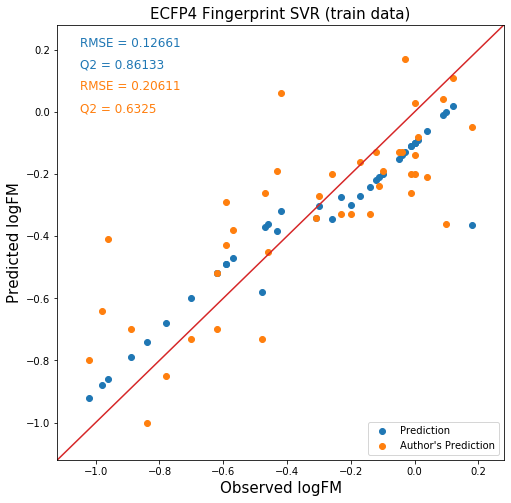

In [25]:
True_Pred_map(y_pred,"SVR")

In [26]:
y_pred = reg.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)
r2_test = r2_score(y_test,y_pred)

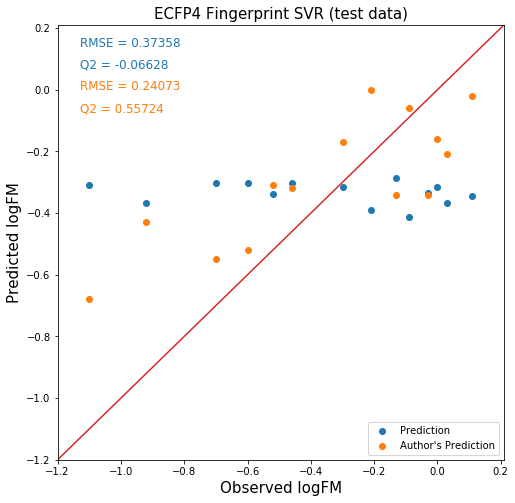

In [27]:
True_Pred_map(y_pred,"SVR")

In [28]:
print("RMSE diff:", abs(rmse_train - rmse_test))
print("R2 diff:", abs(r2_train - r2_test))

RMSE diff: 0.24696715839640526
R2 diff: 0.9276110958390866


### Random Forest Regression

In [29]:
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    min_samples_split = trial.suggest_int("min_samples_split", 2, 16)
    max_leaf_nodes = int(trial.suggest_discrete_uniform("max_leaf_nodes", 4, 64, 4))
    reg = RandomForestRegressor(min_samples_split=min_samples_split,max_leaf_nodes=max_leaf_nodes,criterion="mse",random_state=0)
    reg = LOOCV(reg)
    y_pred = reg.predict(X_train)
    return 1 - r2_score(y_train,y_pred)

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print(study.best_params)
print(study.best_value)
print(study.best_trial)

[I 2020-10-27 11:01:53,655] A new study created in memory with name: no-name-3f85d19a-4759-4a37-a5c6-8d7f7dcd0622
[I 2020-10-27 11:02:00,435] Trial 0 finished with value: 0.3464499526765292 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 28.0}. Best is trial 0 with value: 0.3464499526765292.
[I 2020-10-27 11:02:06,972] Trial 1 finished with value: 0.3471098002394527 and parameters: {'min_samples_split': 10, 'max_leaf_nodes': 4.0}. Best is trial 0 with value: 0.3464499526765292.
[I 2020-10-27 11:02:14,638] Trial 2 finished with value: 0.36334014347871446 and parameters: {'min_samples_split': 16, 'max_leaf_nodes': 60.0}. Best is trial 0 with value: 0.3464499526765292.
[I 2020-10-27 11:02:22,877] Trial 3 finished with value: 0.17145461133400686 and parameters: {'min_samples_split': 5, 'max_leaf_nodes': 12.0}. Best is trial 3 with value: 0.17145461133400686.
[I 2020-10-27 11:02:30,221] Trial 4 finished with value: 0.18907633312801764 and parameters: {'min_samples_split': 6, 'ma

In [30]:
reg = RandomForestRegressor(min_samples_split=study.best_params['min_samples_split'],max_leaf_nodes=int(study.best_params['max_leaf_nodes']),criterion="mse",random_state=0)
reg = LOOCV(reg)

y_pred = reg.predict(X_train)
rmse_train = mean_squared_error(y_train,y_pred,squared=False)
r2_train = r2_score(y_train,y_pred)

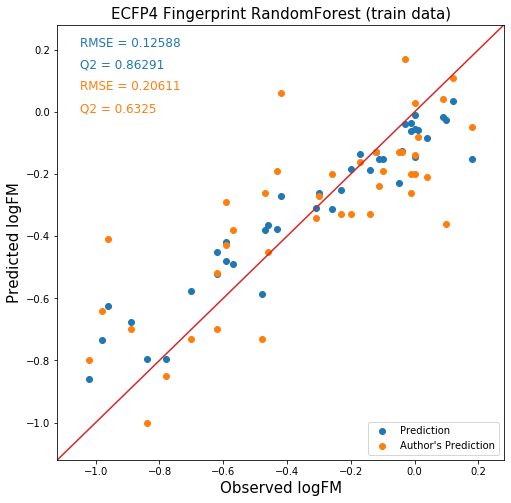

In [31]:
True_Pred_map(y_pred,"RandomForest")

In [32]:
y_pred = reg.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)
r2_test = r2_score(y_test,y_pred)

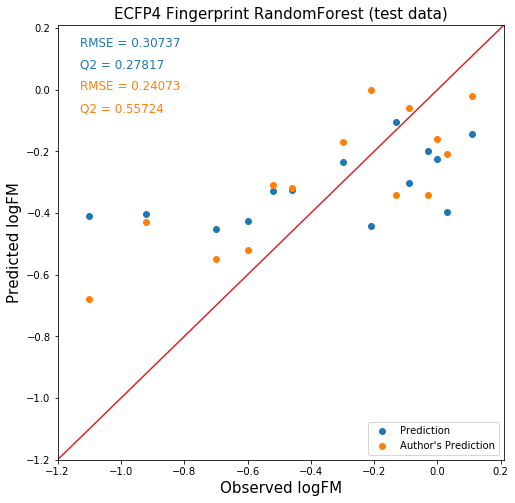

In [33]:
True_Pred_map(y_pred,"RandomForest")

In [34]:
print("RMSE diff:", abs(rmse_train - rmse_test))
print("R2 diff:", abs(r2_train - r2_test))

RMSE diff: 0.1814848984630608
R2 diff: 0.5847390074573964


### LightGBM

In [35]:
import optuna.integration.lightgbm as lgb_o
from sklearn.model_selection import train_test_split

rmse_min = np.inf
for train_index, test_index in loo.split(X_train):
    loo_x_train, loo_x_test = X_train[train_index], X_train[test_index]
    loo_y_train, loo_y_test = y_train[train_index], y_train[test_index]
    lgb_train = lgb_o.Dataset(loo_x_train, loo_y_train)
    lgb_val = lgb_o.Dataset(loo_x_test, loo_y_test)

    params = {'objective': 'regression',
            'metric': 'rmse',
            'verbose': -1} 

    gbm_o = lgb_o.train(params,
                        lgb_train,
                        valid_sets=lgb_val,
                        num_boost_round=10000,
                        early_stopping_rounds=100,
                        verbose_eval=200,)
    y_pred = gbm_o.predict(X_train,num_iteration=gbm_o.best_iteration)
    rmse = mean_squared_error(y_train, y_pred,squared=False)
    if rmse < rmse_min:
        rmse_min = rmse     
        best_model = gbm_o
gbm_o = best_model

	valid_0's rmse: 0.4962
Training until validation scores don't improve for 100 rounds
bagging, val_score: 0.496200:  10%|#         | 1/10 [00:00<00:02,  3.76it/s]Early stopping, best iteration is:
[1]	valid_0's rmse: 0.837
Training until validation scores don't improve for 100 rounds
bagging, val_score: 0.496200:  20%|##        | 2/10 [00:00<00:02,  3.49it/s]Early stopping, best iteration is:
[13]	valid_0's rmse: 0.4962
Training until validation scores don't improve for 100 rounds
bagging, val_score: 0.496200:  30%|###       | 3/10 [00:00<00:02,  3.38it/s]Early stopping, best iteration is:
[13]	valid_0's rmse: 0.4962
Training until validation scores don't improve for 100 rounds
bagging, val_score: 0.496200:  40%|####      | 4/10 [00:01<00:01,  3.54it/s]Early stopping, best iteration is:
[1]	valid_0's rmse: 0.837
Training until validation scores don't improve for 100 rounds
bagging, val_score: 0.496200:  50%|#####     | 5/10 [00:01<00:01,  3.42it/s]Early stopping, best iteration is:
[13

In [36]:
y_pred = gbm_o.predict(X_train,num_iteration=gbm_o.best_iteration)

rmse_train = mean_squared_error(y_train,y_pred,squared=False)
r2_train = r2_score(y_train,y_pred)

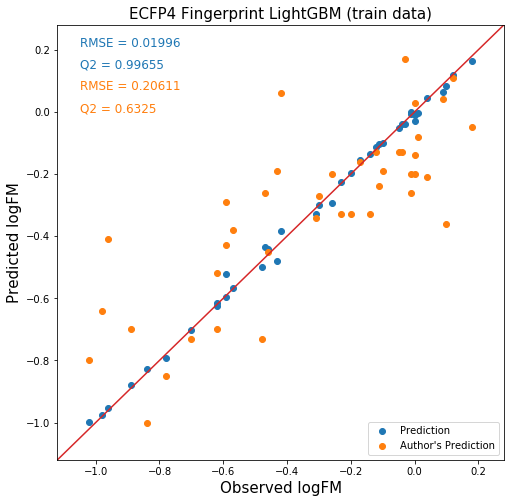

In [37]:
True_Pred_map(y_pred,'LightGBM')

In [38]:
y_pred = gbm_o.predict(X_test,num_iteration=gbm_o.best_iteration)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)
r2_test = r2_score(y_test,y_pred)

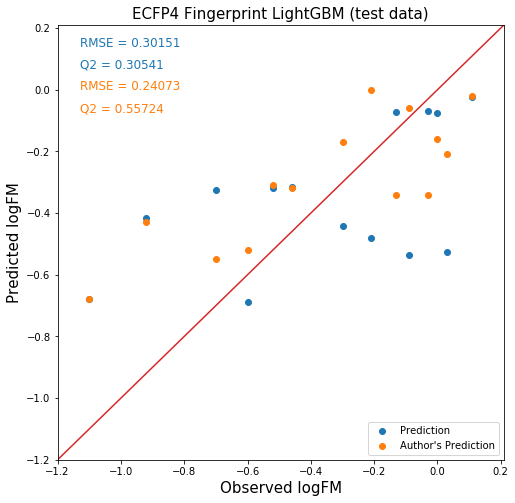

In [39]:
True_Pred_map(y_pred,'LightGBM')

In [40]:
print("RMSE diff:", abs(rmse_train - rmse_test))
print("R2 diff:", abs(r2_train - r2_test))

RMSE diff: 0.281553521945903
R2 diff: 0.6911437231060804
